In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from helper_fn import *

sys.path.append("..")
from modules.utils import paper_style

paper_style()
# path = os.path.join(
#     os.path.dirname(os.path.dirname(os.path.abspath(__file__))), "data/"
# )
path = "../data"
data_path = os.path.join(path, "results/")
gt_path = os.path.join(path, "GT/")

# #  get list of folders in data_path
# folders = [
#     f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))
# ]

# # parse the folder names to get the parameters
# params = [f.split("_") for f in folders]
# heads = [params[i][4] for i in range(len(folders))]
# modalities = [params[i][3] for i in range(len(folders))]

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path)):
    track = np.load(os.path.join(gt_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

track_lengths = [track.shape[0] for track in gt_tracks]

head = "lstm"
modality = "bf"

tracks = get_data(path=data_path, modality=modality, head=head)
fucci_labels = ["green", "red"]

vanilla_track = vanilla_fn(np.linspace(0, 1, 1000))
vanilla_tau = np.linspace(0, 1, 1000)


####################
# analysis of the first head
####################

# head_idx = 0
# head = heads[head_idx]
# head_folder = folders[head_idx]
# head_path = os.path.join(data_path, head_folder)
# track_filenames = os.listdir(head_path)


# # opening tracks in the first folder
# tracks = []
# for i, fn in enumerate(track_filenames):
#     track = np.load(os.path.join(head_path, fn)).squeeze().T
#     tracks.append(track)

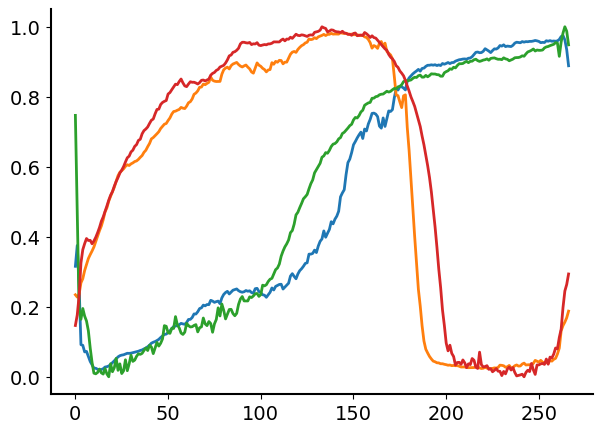

array([0.05400281, 0.05810123])

In [10]:
tracks[0].shape, gt_tracks[0].shape

tr0 = tracks[0]
gt0 = gt_tracks[0]

plt.plot(tr0)
plt.plot(gt0)
plt.show()

np.abs(tr0 - gt0).mean(axis=(0))

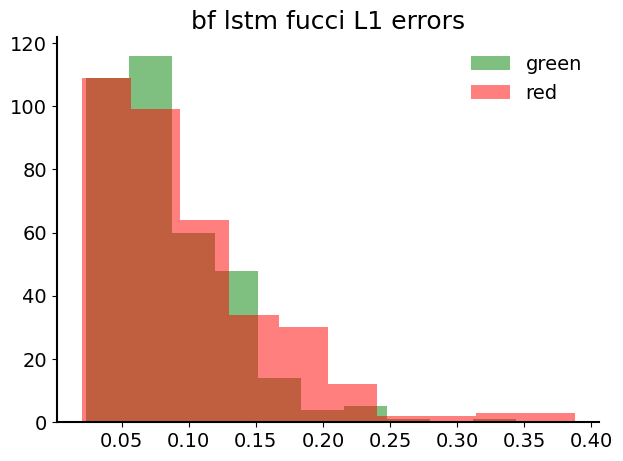

In [ ]:
l1_err = mean_track_error(gt_tracks, tracks, metric="L1", av_channels=False)

fi = 0
plt.title(f"{modality} {head} fucci L1 errors")
plt.hist(l1_err[:, fi], label=fucci_labels[fi], alpha=0.5, color="green")

fi = 1
plt.hist(l1_err[:, fi], label=fucci_labels[fi], alpha=0.5, color="red")

plt.legend()
plt.show()

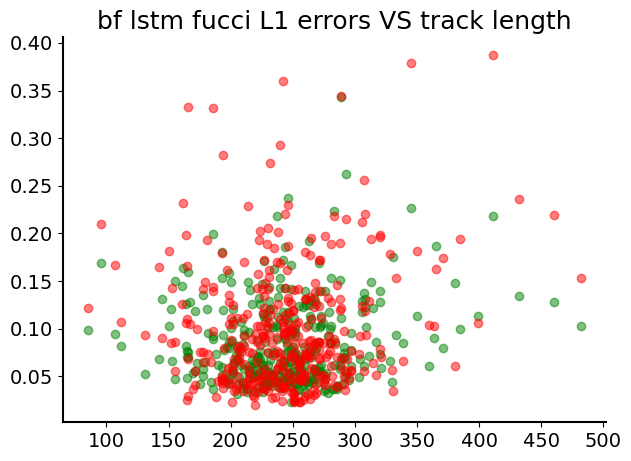

In [12]:
plt.title(f"{modality} {head} fucci L1 errors VS track length")

plt.scatter(
    track_lengths, l1_err[:, 0], label=fucci_labels[0], alpha=0.5, color="green"
)
plt.scatter(track_lengths, l1_err[:, 1], label=fucci_labels[1], alpha=0.5, color="red")

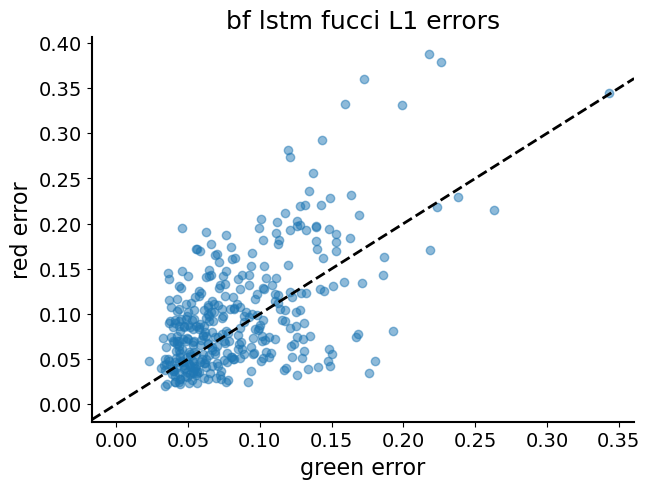

In [13]:
plt.scatter(l1_err[:, 0], l1_err[:, 1], alpha=0.5)
plt.xlabel(f"{fucci_labels[0]} error")
plt.ylabel(f"{fucci_labels[1]} error")

plt.title(f"{modality} {head} fucci L1 errors")

plt.axline([0, 0], slope=1, color="black", linestyle="--")

In [14]:
n_tracks = len(tracks)

errors_g = []
errors_r = []
for i in range(n_tracks):
    error = np.abs(tracks[i] - gt_tracks[i])
    errors_g.append(error[:, 0])
    errors_r.append(error[:, 1])

In [15]:
errors_g_unrolled = np.concatenate(errors_g)
errors_r_unrolled = np.concatenate(errors_r)
taus_unrolled = np.concatenate(taus)

In [16]:
import seaborn as sns

df = pd.DataFrame(
    {
        "tau": taus_unrolled,
        "error_g": errors_g_unrolled,
        "error_r": errors_r_unrolled,
        "fucci": "green",
    }
)

# # density plot taus VS errors_g
# sns.kdeplot(data=df, x="tau", y="error_g", hue="fucci", fill=True)
# plt.show()
# # density plot taus VS errors_g
# sns.kdeplot(data=df, x="tau", y="error_r", hue="fucci", fill=True)

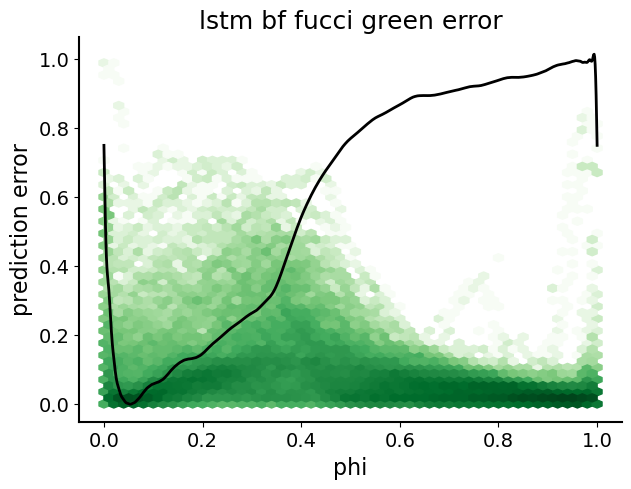

In [24]:
# density plot taus VS errors_g

plt.plot(vanilla_tau, vanilla_track[:, 0], color="black")
plt.hexbin(taus_unrolled, errors_g_unrolled, gridsize=50, cmap="Greens", bins="log")
plt.xlabel("phi")
plt.ylabel("prediction error")
plt.title(f"{head} {modality} fucci green error")
plt.show()

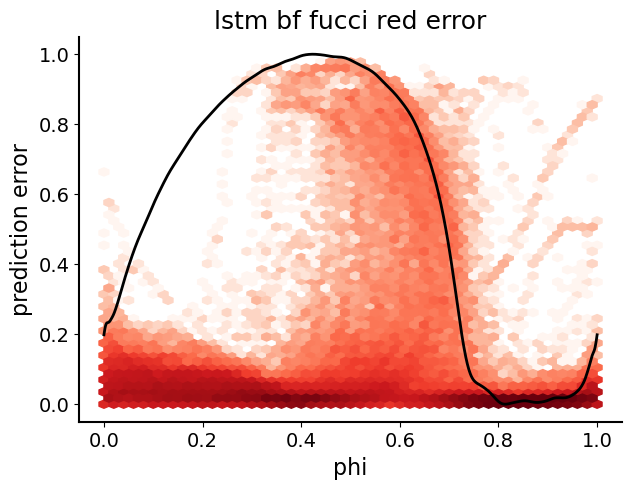

In [25]:
# same for red

plt.plot(vanilla_tau, vanilla_track[:, 1], color="black")
plt.hexbin(taus_unrolled, errors_r_unrolled, gridsize=50, cmap="Reds", bins="log")
plt.xlabel("phi")
plt.ylabel("prediction error")
plt.title(f"{head} {modality} fucci red error")
plt.show()

# log to normal

In [102]:
def find_crossing_green(x, y, th=0.03):
    """
    Return the x-coordinate of the 'meaningful' threshold crossing.
    This is used to find the G1/S transitions.

    Logic:
    1. If y is above threshold for all x in [0, 0.15],
       return 0. (We say the crossing happened at 0.)
    2. Otherwise, find the first time y >= th for x > 0.15.
       If none found, return None.
    """

    # 1) Check if y is >= th *throughout* 0 <= x <= 0.15
    #    That means for all indices where x <= 0.15, y >= th.
    #    We find the indices up to 0.15, and see if y is always above threshold.
    in_early_region = np.where(x <= 0.15)[0]
    if len(in_early_region) > 0:
        # All y values in [0, 0.15] region
        y_early = y[in_early_region]
        if np.all(y_early >= th):
            # Then the signal never dipped below threshold in [0, 0.15]
            return 0

    # 2) Otherwise, we look for the first index i where x[i] > 0.15 and y[i] >= th
    crossing_indices = np.where((x > 0.15) & (y >= th))[0]
    if len(crossing_indices) == 0:
        return None

    # Return the x-coordinate of the first crossing
    return x[crossing_indices[0]]


def find_crossing_red(x, y, threshold=0.02):
    """
    Return the x-coordinate where the signal first drops below `threshold`
    after x > 0.5.
    If no such drop is found, return None.
    """
    # Identify all indices where x > 0.5 and y < threshold
    vanish_indices = np.where((x > 0.5) & (y < threshold))[0]
    if len(vanish_indices) == 0:
        return None
    return x[vanish_indices[0]]


def find_crossing_points(
    taus: list, tracks: list, tr_green: float = 0.03, tr_red: float = 0.02
):
    """
    Find the crossing points for the green and red signals.
    """
    n_tracks = len(tracks)
    crossings = np.zeros((n_tracks, 2))

    for i in range(n_tracks):
        fucci_green = inverse_log_min_max(tracks[i][:, 0])
        fucci_red = inverse_log_min_max(tracks[i][:, 1])

        crossing_green = find_crossing_green(taus[i], fucci_green, tr_green)
        crossing_red = find_crossing_red(taus[i], fucci_red, tr_red)
        crossings[i] = crossing_green, crossing_red

    return crossings

x_crossings_gt = find_crossing_points(taus, gt_tracks)
x_crossings = find_crossing_points(taus, tracks)

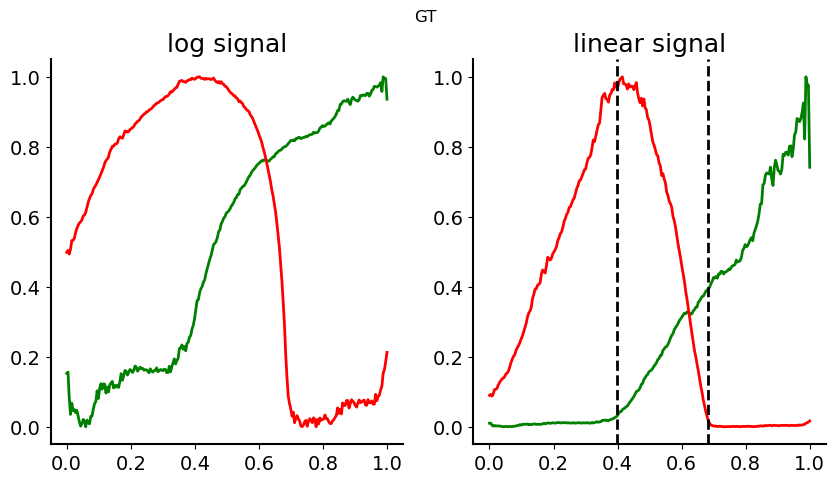

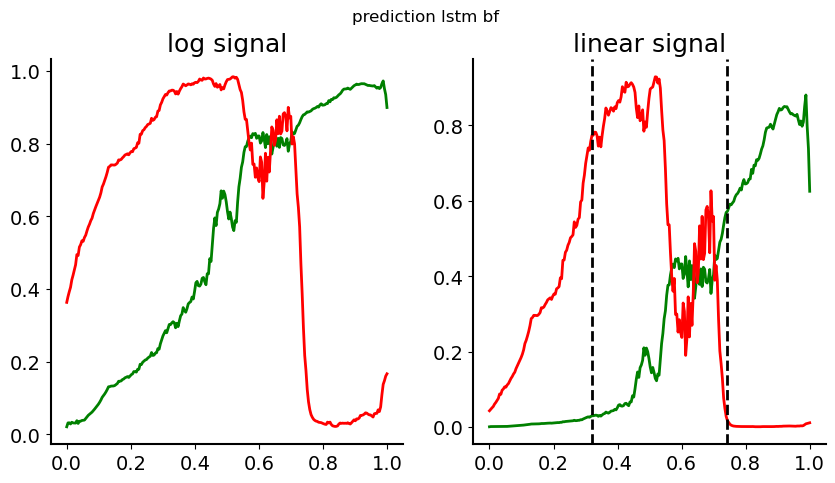

In [129]:
plt.figure(figsize=(10, 5))
plt.suptitle("GT")

idx = np.random.randint(0, n_tracks)

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], gt_tracks[idx][:, 0], color="green")
plt.plot(taus[idx], gt_tracks[idx][:, 1], color="red")

fuc = inverse_log_min_max(gt_tracks[idx], eps=0.01, log_base=np.e)

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:, 0], color="green")
plt.plot(taus[idx], fuc[:, 1], color="red")


plt.axvline(x_crossings_gt[idx, 0], color="black", linestyle="--")
plt.axvline(x_crossings_gt[idx, 1], color="black", linestyle="--")
plt.show()


plt.figure(figsize=(10, 5))
plt.suptitle(f"prediction {head} {modality}")

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], tracks[idx][:, 0], color="green")
plt.plot(taus[idx], tracks[idx][:, 1], color="red")

fuc = inverse_log_min_max(tracks[idx], eps=0.01, log_base=np.e)

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:, 0], color="green")
plt.plot(taus[idx], fuc[:, 1], color="red")


# plt.axhline(th_green, color="black", linestyle="--")
plt.axvline(x_crossings[idx, 0], color="black", linestyle="--")
plt.axvline(x_crossings[idx, 1], color="black", linestyle="--")

In [49]:
# find crossing point for each tracks and gt_tracks
crossings = np.zeros(n_tracks)
gt_crossings = np.zeros(n_tracks)

for i in range(n_tracks):
    track = tracks[i]
    gt_track = gt_tracks[i]

    fuc = inverse_log_min_max(track)
    gt_fuc = inverse_log_min_max(gt_track)

    x_crossing = find_threshold_crossing(taus[i], fuc[:, 0], th)
    x_crossing_gt = find_threshold_crossing(taus[i], gt_fuc[:, 0], th)

    crossings[i] = x_crossing
    gt_crossings[i] = x_crossing_gt

Text(0.5, 0, 'delta crossing (phase units)')

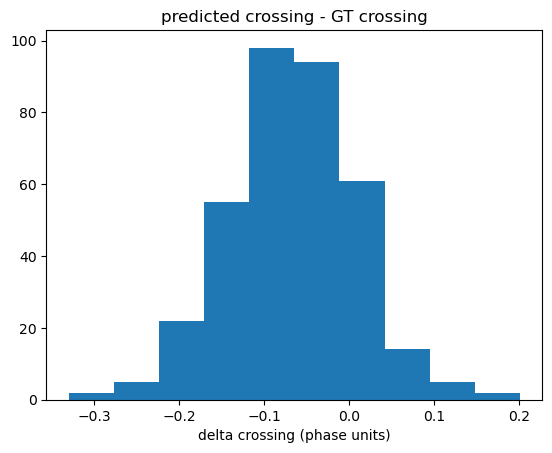

In [50]:
delta_crossings = crossings - gt_crossings

plt.title("predicted crossing - GT crossing")
plt.hist(delta_crossings)
plt.xlabel("delta crossing (phase units)")

array([[0.45488722, 0.69924812],
       [0.22307692, 0.73076923],
       [0.1510989 , 0.59615385],
       [0.23076923, 0.51153846],
       [0.38709677, 0.64112903],
       [0.28222997, 0.55749129],
       [0.27322404, 0.66666667],
       [0.15584416, 0.81168831],
       [0.32      , 0.70666667],
       [0.26839827, 0.5021645 ],
       [0.25095057, 0.54752852],
       [0.24444444, 0.56444444],
       [0.32972973, 0.65405405],
       [0.18548387, 0.50403226],
       [0.24187726, 0.66064982],
       [0.37254902, 0.63235294],
       [0.38235294, 0.66666667],
       [0.36956522, 0.75652174],
       [0.28384279, 0.66375546],
       [0.31343284, 0.71268657],
       [0.27868852, 0.77459016],
       [0.27074236, 0.58078603],
       [0.35582822, 0.79754601],
       [0.32128514, 0.6746988 ],
       [0.27137546, 0.57249071],
       [0.30392157, 0.63235294],
       [0.28054299, 0.70588235],
       [0.16363636, 0.57575758],
       [0.24696356, 0.67611336],
       [0.19305019, 0.53667954],
       [0.